In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import sys
import random

In [2]:
sys.path.insert(0, '..')

In [3]:
from convlstm_classes import ConvLSTM

In [4]:
future_steps = 30

Below, dataset is the original dataset, with non-normalized features and containing nan values. dataset_norm has the features normalized and nan values replaced by 0.

In [5]:
dataset = torch.tensor(np.load('../../../numpy_dataset/dataset.npy'))

In [6]:
dataset_norm = torch.tensor(np.load('../../../numpy_dataset/dataset_normalized.npy'))

The input X consists of the first 11 days of data (the current day preceded by 10 days of lag). The target y consists of the rest of the data (30 days of lead). y_un contains nan values and will be used to create a mask.

In [7]:
X = dataset_norm[:,:11,:,:,:]

y = dataset_norm[:,11:,:,:,:]

y_un = dataset[:,11:,:,:,:]

In [8]:
# Load the model
model = ConvLSTM(input_dim=8, hidden_dim=8, kernel_size=(3,3), num_layers=3,
                 batch_first=True, bias=True, return_all_layers=True, dropout_prob=0.3,
                 output_size=30, output_channel=1)

model.load_state_dict(torch.load('../best_model_params.pt', map_location=torch.device('cpu')))

model.eval()

ConvLSTM(
  (cell_list): ModuleList(
    (0-2): 3 x ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (batchnorm_list1): ModuleList(
    (0-2): 3 x BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout_list1): ModuleList(
    (0-2): 3 x Dropout(p=0.3, inplace=False)
  )
  (batchnorm_list2): ModuleList(
    (0-2): 3 x BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout_list2): ModuleList(
    (0-2): 3 x Dropout(p=0.3, inplace=False)
  )
)

In [9]:
full_len = len(X)

In [10]:
test_len = int(len(X) * 0.2)

In [11]:
for_mask = y_un[-test_len:,:,1]

In [12]:
X_test = X[-test_len:]

In [13]:
y_test = y[-test_len:,:,1]

Our baseline model predicts oxygen to stay constant at each longitude and latitude, for all 30 days. This is recorded in y_base. y_pred is the oxygen predicted by the model.

In [14]:
y_pred = model(X_test).squeeze(2).detach().numpy()

In [15]:
y_base = torch.stack(future_steps * [X_test[:,-1,1]], 1)

We use the nan values of for_mask to create a mask for y_test, y_pred, y_base.

In [16]:
y_test = np.ma.masked_where(for_mask.isnan(), y_test)

In [17]:
y_pred = np.ma.masked_where(for_mask.isnan(), y_pred)

In [18]:
y_base = np.ma.masked_where(for_mask.isnan(), y_base)

In [19]:
baseline_error = np.mean((y_base - y_test)**2)

In [20]:
model_error = np.mean((y_pred - y_test)**2)

Here are the errors of the baseline model versus the neural network model.

In [21]:
print(f'Baseline mean squared error: {baseline_error:.5}')
print(f'Model mean squared error: {model_error:.5}')

Baseline mean squared error: 0.063958
Model mean squared error: 0.051773


We'll track the error by day for the baseline model and the neural network model.

In [22]:
baseline_error_by_day = [np.mean((y_base[:,i] - y_test[:,i])**2) for i in range(future_steps)]

In [23]:
model_error_by_day = [np.mean((y_pred[:,i] - y_test[:,i])**2) for i in range(future_steps)]

Here we plot the errors made by the baseline model and the neural network model by day. We see that the neural network does slightly worse than the baseline model at the beginning, but does significantly better by the end.

In [24]:
with open('convlstm_errors.txt', 'w') as f:
    for i in range(30):
        f.write(str(model_error_by_day[i]) + '\n')

In [25]:
with open('baseline_errors.txt', 'w') as f:
    for i in range(30):
        f.write(str(baseline_error_by_day[i]) + '\n') 

Text(0.5, 1.0, 'Mean squared error by day for baseline and ConvLSTM stack model')

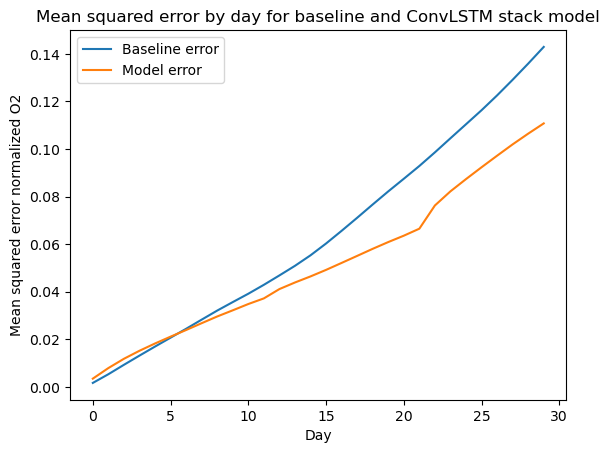

In [26]:
plt.plot(baseline_error_by_day, label='Baseline error')
plt.plot(model_error_by_day, label='Model error')
plt.xlabel('Day')
plt.ylabel('Mean squared error normalized O2')
plt.legend()
plt.savefig('mse.pdf', format='pdf')
plt.title('Mean squared error by day for baseline and ConvLSTM stack model')

In [27]:
print('Mean squared error by day\n')
for i in range(30):
    print(f'Day {i+1}')
    print(f'Mean squared error by day for baseline model: {baseline_error_by_day[i]:.5f}')
    print(f'Mean squared error by day for ConvLSTM model: {model_error_by_day[i]:.5f}\n')

Mean squared error by day

Day 1
Mean squared error by day for baseline model: 0.00165
Mean squared error by day for ConvLSTM model: 0.00346

Day 2
Mean squared error by day for baseline model: 0.00531
Mean squared error by day for ConvLSTM model: 0.00790

Day 3
Mean squared error by day for baseline model: 0.00927
Mean squared error by day for ConvLSTM model: 0.01180

Day 4
Mean squared error by day for baseline model: 0.01313
Mean squared error by day for ConvLSTM model: 0.01517

Day 5
Mean squared error by day for baseline model: 0.01694
Mean squared error by day for ConvLSTM model: 0.01823

Day 6
Mean squared error by day for baseline model: 0.02068
Mean squared error by day for ConvLSTM model: 0.02110

Day 7
Mean squared error by day for baseline model: 0.02441
Mean squared error by day for ConvLSTM model: 0.02390

Day 8
Mean squared error by day for baseline model: 0.02826
Mean squared error by day for ConvLSTM model: 0.02676

Day 9
Mean squared error by day for baseline model: 0

Below we plot the predicted O2 (by the ConvLSTM model) and actual O2 for 20 random locations (longitude,latitude) and 20 random starting dates.

In [28]:
np.random.seed(42)

In [29]:
non_masked_indices = [(i,j) for i in range(10) for j in range(20) if not y_test.mask[0,0,i,j]]

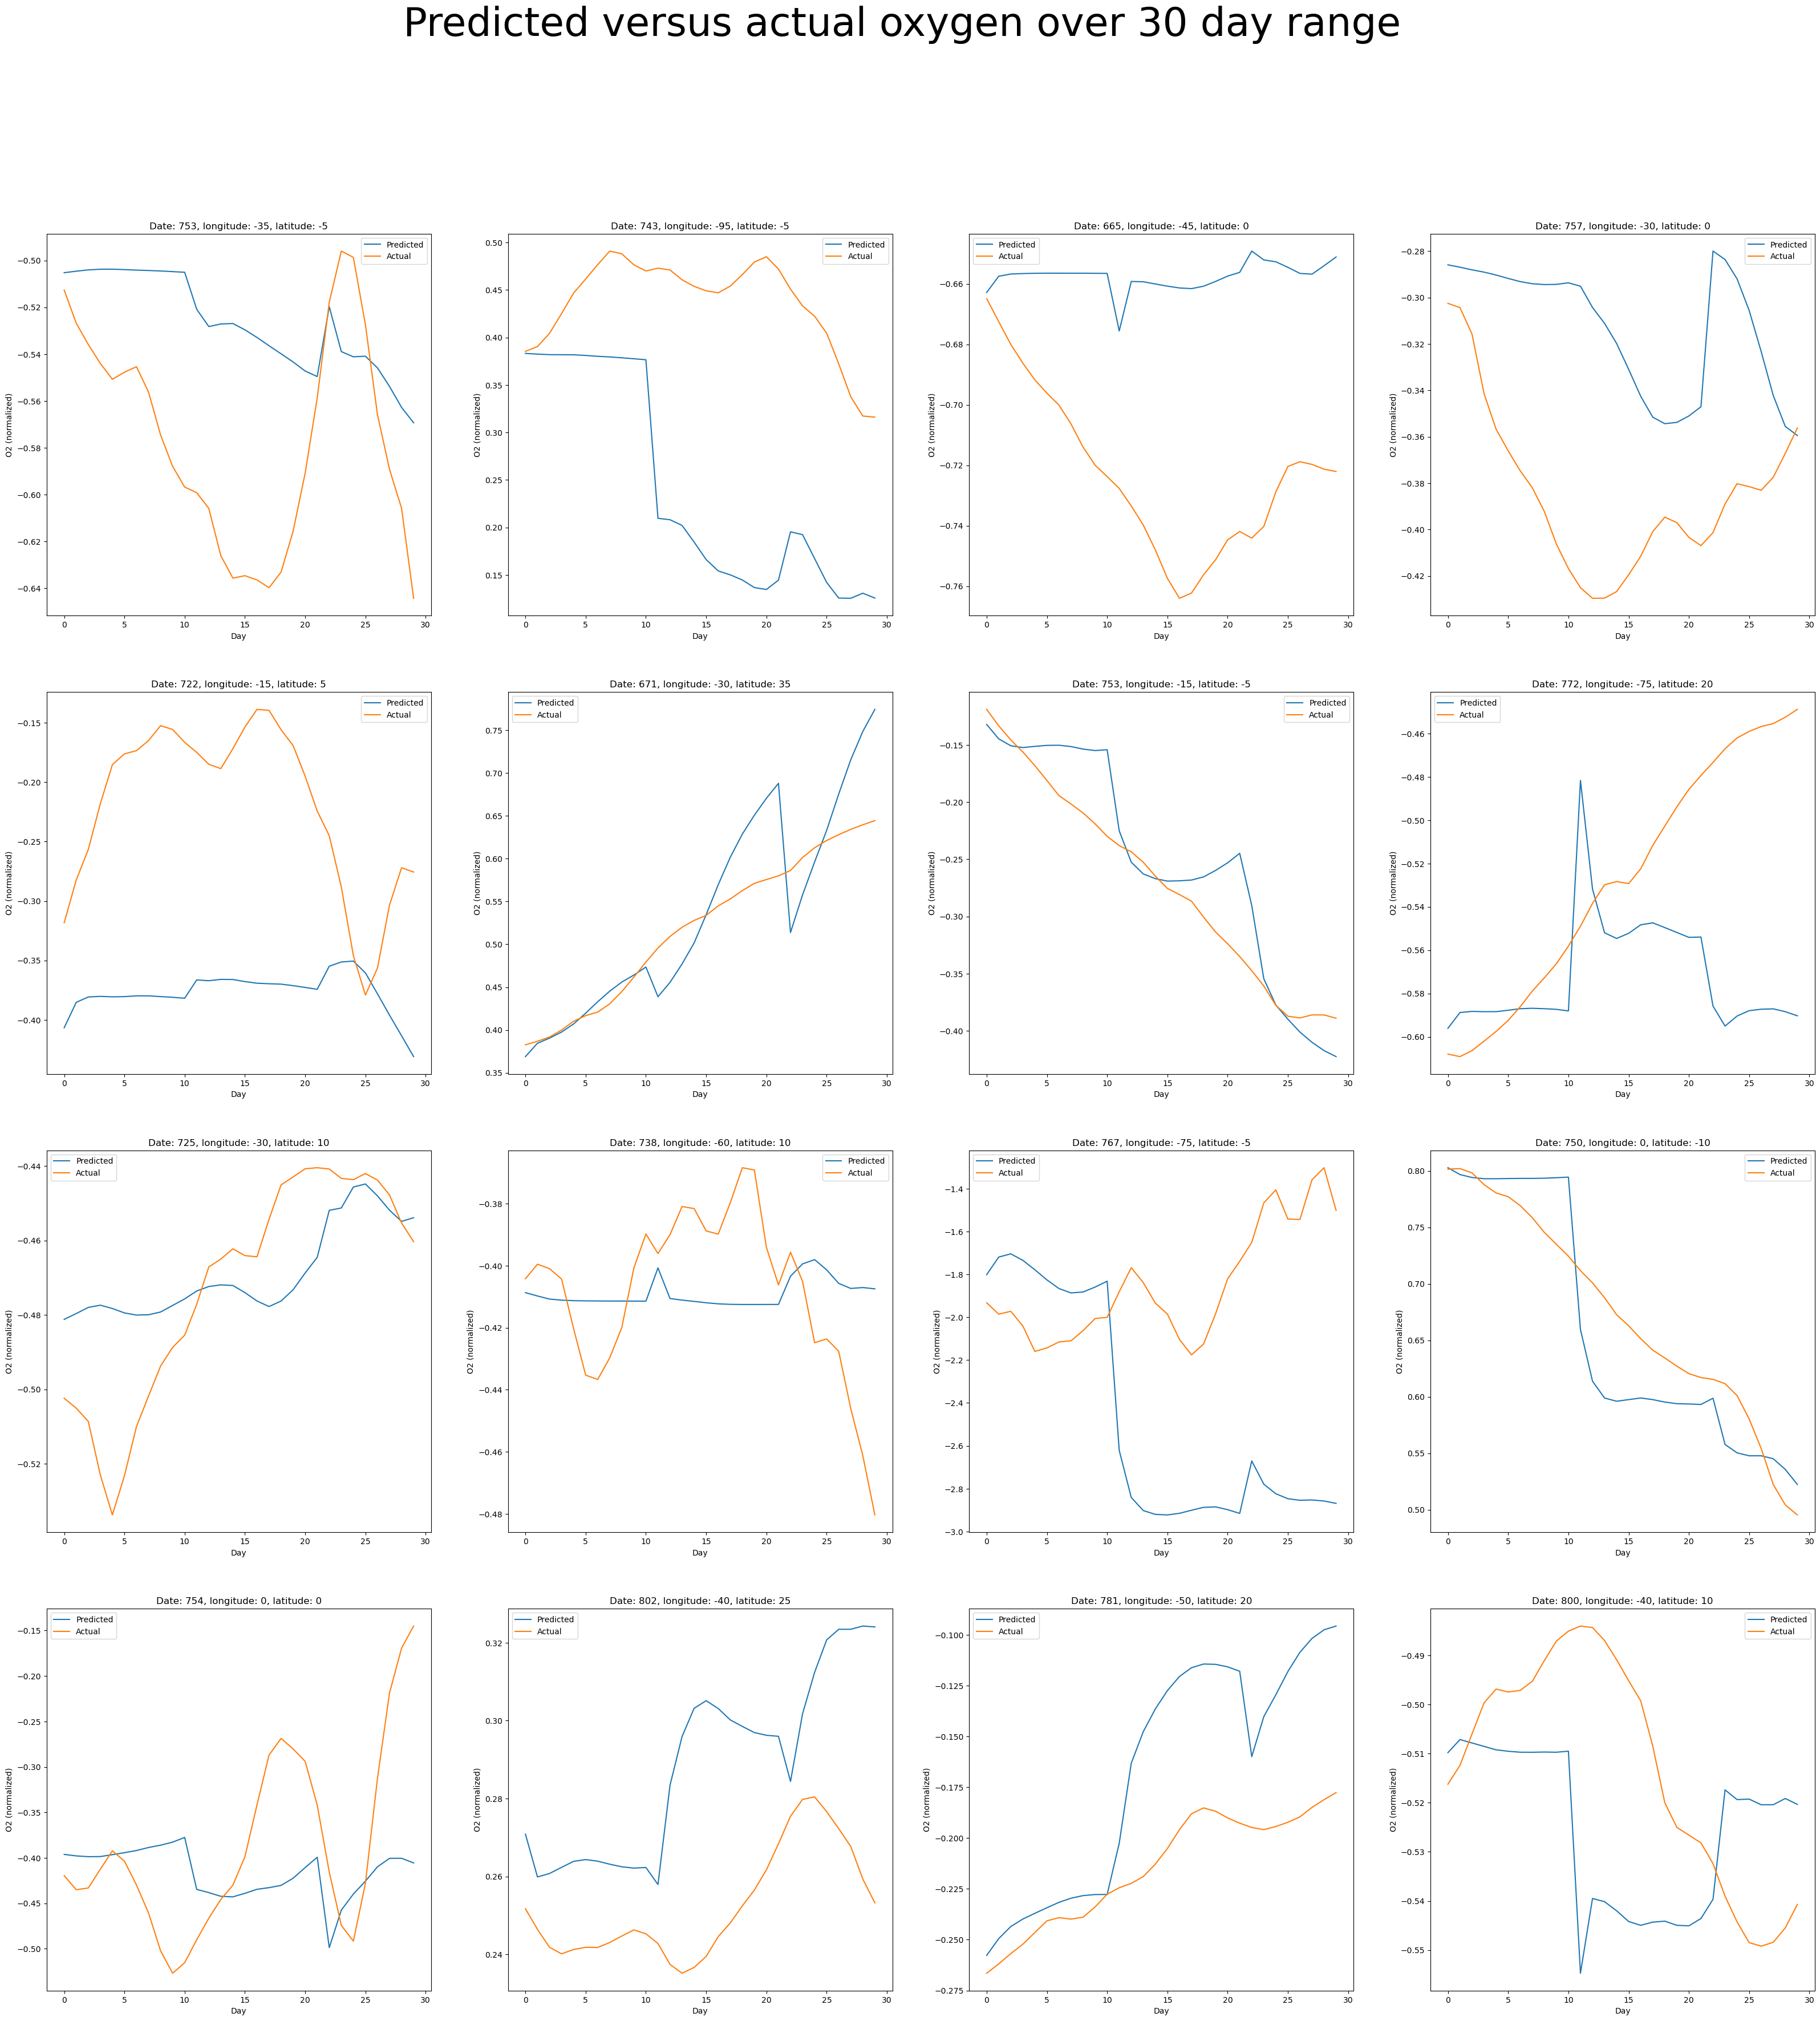

In [30]:
fig, axes = plt.subplots(4, 4, figsize=(40,40))
for i in range(16):
    # Choose a random point and random start date
    lat, lon = random.choice(non_masked_indices)
    date = np.random.randint(low=0, high=test_len)
    # true and pred contain the true O2 and predicted O2 30 days in the future
    true = y_test[date, :, lat, lon]
    pred = y_pred[date, :, lat, lon]
    
    ax = axes[i // 4][i % 4]
    ax.plot(range(30), pred, label='Predicted')
    ax.plot(range(30), true, label='Actual')
    
    ax.set_xlabel('Day')
    ax.set_ylabel('O2 (normalized)')
    ax.legend()
    ax.set_title(f'Date: {date + full_len - test_len}, longitude: {-95 + 5*lon}, latitude: {-10 + 5*lat}')

fig.suptitle('Predicted versus actual oxygen over 30 day range', fontsize=50)
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('predicted_o2.pdf', format='pdf', bbox_inches='tight')
plt.show()